In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from se3cnn.util.plot import spherical_harmonics_coeff_to_sphere

In [4]:
import plotly.graph_objects as go

In [5]:
import vistools
import otp
import cgae.cgae

In [6]:
def traces_lines(ar, color='red'):
    def trace_two(a):
        x, y, z = a.T
        trace = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='lines',
            line=dict(color=color, width=4)
        )
        return trace
    
    pairs = [np.asarray(i) for i in combinations(ar, 2)]
    traces = [trace_two(i) for i in pairs]
    return traces

# It all starts here

In [7]:
def load_batched_xyz(pkl):
    args = pkl['args']
    args.device = 'cpu'
    xyz, forces, features = otp.data(pkl['args'])
    n_batches, xyz, forces, features = otp.batch(xyz, forces, features, pkl['args'].bs)
    return n_batches, xyz, forces, features

In [8]:
ls -lht *.pkl

-rw-r--r--  1 bkmiller  staff   2.5M Sep 24 16:50 overfit.pkl
-rw-r--r--  1 bkmiller  staff   2.5M Sep 20 12:38 out.pkl
-rw-r--r--  1 bkmiller  staff   1.2M Sep 20 11:26 sph_overfit_deep.pkl
-rw-r--r--  1 bkmiller  staff   517K Sep 20 11:26 sph_overfit_smallbatch.pkl
-rw-r--r--  1 bkmiller  staff   1.6M Sep 20 11:17 sph_overfit_nearest.pkl
-rw-r--r--  1 bkmiller  staff   1.5M Sep 20 11:16 sph_overfit.pkl
-rw-r--r--  1 bkmiller  staff    17M Sep 19 12:19 sph.pkl
-rw-r--r--  1 bkmiller  staff    29M Sep 18 16:50 dense.pkl
-rw-r--r--  1 bkmiller  staff    23M Sep 17 14:37 dense_nofm.pkl
-rw-r--r--  1 bkmiller  staff    79M Sep 17 10:43 gsm_long.pkl
-rw-r--r--  1 bkmiller  staff    89M Sep 17 10:43 both_long.pkl
-rw-r--r--  1 bkmiller  staff    89M Sep 17 10:43 both_gsm_long.pkl
-rw-r--r--  1 bkmiller  staff    11M Sep 16 15:07 edde_short.pkl
-rw-r--r--  1 bkmiller  staff    11M Sep 16 15:07 edde_gsm_short.pkl
-rw-r--r--  1 bkmiller  staff    11M Sep 16 15:07 both_short.pkl
-rw-r--r--  1 b

In [9]:
# Select save data here
PICKLE = 'overfit.pkl'

pkl = torch.load(PICKLE, map_location='cpu')
_, xyz, _, features = load_batched_xyz(pkl)

In [10]:
steps = len(pkl['dynamics'])
epochs = pkl['dynamics'][-1]['epoch']
print(f"There are {steps} steps.")
print(f"Corresponding to {epochs} epochs.")
print(f"i.e. about {steps/epochs} steps/epoch")

KeyError: 'epoch'

KeyError: 'loss_ae_dense'

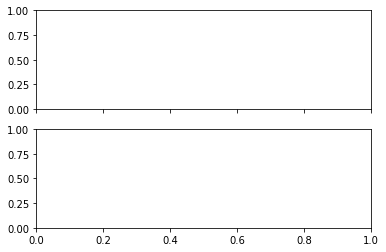

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
loss = [i['loss'] for i in pkl['dynamics']]
try:
    loss_ae = [i['loss_ae'] for i in pkl['dynamics']]
except KeyError:
    plotboth = True
    loss_ae_equi = [i['loss_ae_equi'] for i in pkl['dynamics']]
    loss_ae_dense = [i['loss_ae_dense'] for i in pkl['dynamics']]
loss_fm = [i['loss_fm'] for i in pkl['dynamics']]

ax[0].plot(loss, label='total loss')
ax[0].plot(loss_fm, label='force match')
ax[0].legend()

if plotboth:
    ax[1].plot(loss_ae_equi, label='loss_ae_equi')
    ax[1].plot(loss_ae_dense, label='loss_ae_dense')
    ax[1].legend()
else:
    ax[1].plot(loss_ae, label='autoenc')
    ax[1].legend()

fig.tight_layout()
plt.show()
plt.savefig('loss.png')

# Visualize frame

In [13]:
epoch = 14
example = 0

In [15]:
temp = pkl['summaries'][epoch]['temp']
batch = pkl['summaries'][epoch]['batch']
geo = xyz[batch, example].detach().numpy()
gumble = pkl['summaries'][epoch]['gumble']
st_gumble = pkl['summaries'][epoch]['st_gumble']
if len(gumble.shape) == 3:
    gumble = gumble[example]
    st_gumble = st_gumble[example]
nearest = pkl['summaries'][epoch]['nearest'][example]

cg_xyz = pkl['summaries'][epoch]['cg_xyz'][example].detach().numpy()

print(temp, batch)

3.7954516410827637 37


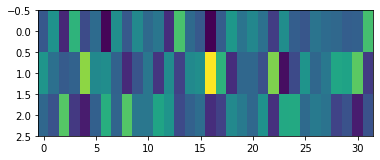

In [16]:
plt.imshow(gumble.detach().cpu().numpy().T, aspect=4)
# plt.xticks(np.arange(32))
# plt.yticks(np.arange(3))
# plt.yticks(np.arange(pkl['args'].ncg), ["CG" + str(i+1) for i in range(N_cg)])
plt.show()

In [17]:
def ylms_to_surface(ylms, center):
    xyz_signal = vistools.sh_coeff_to_xyz_signal(ylms, angular_resolution=100, r_scale=0.5)
    surface = vistools.xyz_signal_to_surface(xyz_signal, center)
    return surface

colors = ['red', 'green', 'blue']
colormap = {i: c for i, c in enumerate(colors)}

In [18]:
cg_sph = pkl['summaries'][epoch]['pred_sph'][example].detach().numpy()
cg_sph_0 = pkl['summaries'][epoch]['pred_sph'][example, :, :36].detach().numpy()
cg_sph_1 = pkl['summaries'][epoch]['pred_sph'][example, :, 36:].detach().numpy()
sph_0 = pkl['summaries'][epoch]['sph'][example, :, :36].detach().numpy()
sph_1 = pkl['summaries'][epoch]['sph'][example, :, 36:].detach().numpy()

# Truth

In [19]:
# Hydrogen signal
data = [ylms_to_surface(ylms=sph_0[i], center=cg_xyz[i]) for i in range(3)]

for color in colors:
    if pkl['args'].nearest:
        mask = vistools.assignment_to_color(nearest, colormap) == color
    else:
        mask = vistools.assignment_to_color(st_gumble, colormap) == color
    data += [vistools.trace_pts(geo[mask.flatten()], color=color)]

fig = go.Figure(data=data)
fig.show()

AttributeError: 'Namespace' object has no attribute 'nearest'

In [ ]:
# Carbon signal
data = [ylms_to_surface(ylms=sph_1[i], center=cg_xyz[i]) for i in range(3)]

for color in colors:
    if pkl['args'].nearest:
        mask = vistools.assignment_to_color(nearest, colormap) == color
    else:
        mask = vistools.assignment_to_color(st_gumble, colormap) == color
    data += [vistools.trace_pts(geo[mask.flatten()], color=color)]

fig = go.Figure(data=data)
fig.show()

# Predicted

In [ ]:
# Hydrogen signal
data = [ylms_to_surface(ylms=cg_sph_0[i], center=cg_xyz[i]) for i in range(3)]

for color in colors:
    if pkl['args'].nearest:
        mask = vistools.assignment_to_color(nearest, colormap) == color
    else:
        mask = vistools.assignment_to_color(st_gumble, colormap) == color
    data += [vistools.trace_pts(geo[mask.flatten()], color=color)]

fig = go.Figure(data=data)
fig.show()

In [ ]:
# Carbon signal
data = [ylms_to_surface(ylms=cg_sph_1[i], center=cg_xyz[i]) for i in range(3)]

for color in colors:
    if pkl['args'].nearest:
        mask = vistools.assignment_to_color(nearest, colormap) == color
    else:
        mask = vistools.assignment_to_color(st_gumble, colormap) == color
    data += [vistools.trace_pts(geo[mask.flatten()], color=color)]

fig = go.Figure(data=data)
fig.show()

# Complete overfit

In [21]:
if True:
    def ylms_to_surface(ylms, center):
        xyz_signal = vistools.sh_coeff_to_xyz_signal(ylms, angular_resolution=100, r_scale=0.5)
        surface = vistools.xyz_signal_to_surface(xyz_signal, center)
        return surface

    colors = ['red', 'green', 'blue']
    colormap = {i: c for i, c in enumerate(colors)}
    
    # Overfit
    PICKLE = 'overfit.pkl'

    pkl = torch.load(PICKLE, map_location='cpu')
    _, xyz, _, features = load_batched_xyz(pkl)

    step = 999
    pred_sph = [i['pred_sph'] for i in pkl['summaries']]
#     pred_sph = [i['sph'] for i in pkl['summaries']]

    cg_sph_0 = pred_sph[step][0, :, :36].detach().numpy()
    cg_sph_1 = pred_sph[step][0, :, 36:].detach().numpy()
    cg_xyz = pkl['summaries'][step]['cg_xyz'][0]
    nearest = pkl['summaries'][step]['nearest'][0]
    pkl['args'].nearest = True
    geo = torch.tensor([[[2.95687, -0.155487, 2.11914],
                         [2.06787, 0.671653, 1.43503],
                         [0.850204, 1.00373, 2.03273],
                         [0.601561, 0.628464, 3.40416],
                         [1.56987, -0.160152, 4.10868],
                         [2.7057, -0.572914, 3.4475],
                         [-0.660677, 0.987154, 4.01818],
                         [-1.5062, -0.0960717, 4.51092],
                         [-2.79988, 0.102162, 5.03003],
                         [-3.24092, 1.39391, 5.26613],
                         [-2.4742, 2.51713, 4.79282],
                         [-1.26258, 2.37251, 4.09869],
                         [-0.543147, 3.54105, 3.57502],
                         [0.705632, 3.706, 4.07958],
                         [1.4324, 4.92182, 3.79255],
                         [0.943385, 5.85763, 2.93262],
                         [-0.394225, 5.73001, 2.50639],
                         [-1.12944, 4.62928, 2.87664],
                         [3.87787, -0.345135, 1.63161],
                         [2.28279, 0.994601, 0.40769],
                         [0.0681252, 1.5429, 1.54221],
                         [1.31643, -0.405288, 5.13049],
                         [3.50865, -0.971784, 4.06418],
                         [-1.18795, -1.17369, 4.3918],
                         [-3.36382, -0.788193, 5.36065],
                         [-4.20054, 1.44102, 5.74857],
                         [-2.98015, 3.51865, 4.87225],
                         [1.22583, 3.04857, 4.6967],
                         [2.46003, 5.08062, 4.05937],
                         [1.53019, 6.73809, 2.68288],
                         [-0.856573, 6.50135, 1.8472],
                         [-2.14819, 4.48423, 2.48099]]])[0].detach().numpy()

    print(cg_xyz.shape, cg_sph_1.shape)
    
    # Carbon signal
    data = [ylms_to_surface(ylms=cg_sph_1[i], center=cg_xyz[i]) for i in range(3)]

    for color in colors:
        if pkl['args'].nearest:
            mask = vistools.assignment_to_color(nearest, colormap) == color
        else:
            mask = vistools.assignment_to_color(st_gumble, colormap) == color
        data += [vistools.trace_pts(geo[mask.flatten()], color=color)]

    fig = go.Figure(data=data)
    fig.show()

torch.Size([3, 3]) (3, 36)


In [22]:
pred_sph[0].shape

torch.Size([1, 3, 72])